In [1]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import time
from torch import nn
from torch.utils.data import DataLoader
from load_data import MyData  # self-made
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm # View procedure
import os
import scipy.io
from random import random
import numpy as np
import gc
from torch.utils.tensorboard import SummaryWriter
from network_cnn_lstm import MyNetwork
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load Test Data

In [2]:
# exper_dir = "rest"
exper_dir = "conditionC"
root_dir = f"../data/eegmap_split/{exper_dir}"
test_data = []
test_label = []
# # ---- hc
# dataset = MyData(root_dir, f"test", "hc") # hc
# # find the fold file
# for person in range(len(dataset)):
#     filename = os.path.join(dataset.path, dataset.file_path[person])
#     data_map = torch.load(filename)
#     print(f"data_map size: {data_map.size()}")
#     # extract the pure name of the file
#     parts = filename.split("\\")
#     file_name = parts[-1]
#     name_without_extension = file_name.split(".")[0]
#     # label or data
#     file_last = name_without_extension.split("_")[-1]
#     if file_last == "label": # label
#         for label in data_map:
#             test_label.append(label)
#     else: # data
#         for data in data_map:
#             test_data.append(data)
#     del filename, parts, name_without_extension, file_last
#     gc.collect()
#     torch.cuda.empty_cache()   
# ---- mcs
dataset = MyData(root_dir, "test", "mcs") 
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
    print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
# ---- uws
dataset = MyData(root_dir, "test", "uws") # uws
# find the fold file
for person in range(len(dataset)):
    filename = os.path.join(dataset.path, dataset.file_path[person])
    data_map = torch.load(filename)
    print(f"data_map size: {data_map.size()}")
    # extract the pure name of the file
    parts = filename.split("\\")
    file_name = parts[-1]
    name_without_extension = file_name.split(".")[0]
    # label or data
    file_last = name_without_extension.split("_")[-1]
    if file_last == "label": # label
        for label in data_map:
            test_label.append(label)
    else: # data
        for data in data_map:
            test_data.append(data)
    del filename, parts, name_without_extension, file_last
    gc.collect()
    torch.cuda.empty_cache()  
test_data = torch.stack(test_data)
test_label = torch.stack(test_label)
print(test_data.size())
print(test_label.size())
test_data_size = test_label.size()

data_map size: torch.Size([135, 2400, 10, 11])
data_map size: torch.Size([135])
data_map size: torch.Size([122, 2400, 10, 11])
data_map size: torch.Size([122])
torch.Size([257, 2400, 10, 11])
torch.Size([257])


# Hyperparameters

In [3]:
BATCH_SIZE = 1
C,H,W = 1,1,2400
learn_rate = 0.0005
num_epochs = 100

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# test dataset
test_td = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_td, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
del test_data
del test_label
del test_td
gc.collect()
torch.cuda.empty_cache()

# Ensuring deterministicity through Random seeding

In [6]:
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 4
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)

# Load Model

In [7]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()
# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量

# ==损失函数权重
# ======== 二分类-HC/DOC
# 计算总样本数量
# condition1
# total_samples = 887 + 985 + 879
# condition2
# total_samples = 929 + 1029 + 886
# condition3
# total_samples = 887 + 975 + 879
# 计算每个类别的权重
# condition1
# weights = [total_samples / 887, total_samples / (985 + 879)]
# condition2
# weights = [total_samples / 929, total_samples / (1029 + 886)]
# condition3
# weights = [total_samples / 887, total_samples / (975 + 879)]
# ======== 二分类-MCS/UWS
# 计算总样本数量
# condition1
# total_samples =985 + 879
# condition2
# total_samples = 1029 + 886
# condition3
# total_samples = 975 + 879
# 计算每个类别的权重
# condition1
# weights = [total_samples / 985, total_samples / 879]
# condition2
# weights = [total_samples / 1029, total_samples / 886]
# condition3
# weights = [total_samples / 975, total_samples / 879]
# # ======== 三分类
# # 计算总样本数量
# # conditionB
# total_samples = 929 + 1029 + 886
# # 计算每个类别的权重
# # conditionB
# weights = [total_samples / 929, total_samples / 1029, total_samples / 886]

# condition3-HC/DOC
# total_samples = 887 + 975 + 879
# weights = [total_samples / 887, total_samples / (975 + 879)]
# condition3-MCS/UWS
total_samples = 975 + 879
weights = [total_samples / 975, total_samples / 879]
# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)
# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = criterion.to(device)
# 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)
# 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = criterion.to(device)
from network_cnn_lstm_4 import MyNetwork
fold = 0
begin = 3
end = 80
exper_dir = "conditionC"
classification = "mcs_uws"
model_name = "_CNN_spa_lstm"
print(f"../model/{classification}/{exper_dir}{model_name}/Fold{fold}.pt")
for i in tqdm(range(begin,end)):
    model = MyNetwork(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold{fold}_Epoch{i}.pt"))
    model = model.to(device)
    # 测试步骤开始
    model.eval()
    # 初始化损失和准确率
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    total_test_loss = 0
    # 计数
    test_count = 0
    # 用于绘制混淆矩阵
    predicted_labels = torch.tensor([])
    predicted_labels = predicted_labels.to(device)
    true_labels = torch.tensor([])
    true_labels = true_labels.to(device)
    with torch.no_grad(): # 设置不进行后向传播
        for data in test_loader:
            test_count = test_count + 1
            data_map, label=data # x,y
            # x
            data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
            data_map_reshaped = data_map_reshaped.to(device)
            # y
            label_int = label.long()
            label_int = label_int.to(device)
            # clear gpu
            del data_map
            del label
            gc.collect()
            torch.cuda.empty_cache()
            # y_pred
            label_pred_test = model(data_map_reshaped)

            # confusion matrix
            predicted_labels = torch.cat((predicted_labels, label_pred_test.argmax(1)), dim=0)
            true_labels = torch.cat((true_labels, label_int), dim=0)

            # loss
            loss = criterion(label_pred_test,label_int)
            total_test_loss = total_test_loss + loss.item()

            pred_label = ((label_pred_test.argmax(1)) == label_int).sum()
            # calculation
            if label_int == 1: # DOC
                if pred_label == 1: # 预测对了
                    TP = TP + 1
                elif pred_label ==0: # 预测错了
                    FN = FN + 1
            if label_int == 0: # HC
                if pred_label == 1: # 预测对了
                    TN = TN + 1
                elif pred_label == 0: # 预测错了
                    FP = FP + 1
    print(f"=====================Epoch {i} == Loss:{total_test_loss}===============")
    print(f"--Accuracy: {(TP + TN) / (TP + TN + FP + FN)}")
    print(f"--Precision: {TP / (TP + FP)}")
    print(f"--Recall: {TP / (TP + FN)}")
    del model,TP,TN,FP,FN,total_test_loss,test_count
    gc.collect()
    torch.cuda.empty_cache()

../model/mcs_uws/conditionC_CNN_spa_lstm/Fold0.pt


D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/77 [00:00<?, ?it/s]

=====================Epoch 3 == Loss:171.87330772849964===============
--Accuracy: 0.669260700389105
--Precision: 0.9743589743589743
--Recall: 0.3114754098360656
=====================Epoch 4 == Loss:71.15324583489286===============
--Accuracy: 0.8949416342412452
--Precision: 0.8321678321678322
--Recall: 0.9754098360655737
=====================Epoch 5 == Loss:46.826896618270034===============
--Accuracy: 0.9260700389105059
--Precision: 0.8814814814814815
--Recall: 0.9754098360655737
=====================Epoch 6 == Loss:50.60408944884892===============
--Accuracy: 0.9494163424124513
--Precision: 0.916030534351145
--Recall: 0.9836065573770492
=====================Epoch 7 == Loss:147.28214397702504===============
--Accuracy: 0.7821011673151751
--Precision: 1.0
--Recall: 0.5409836065573771
=====================Epoch 8 == Loss:27.495455808717715===============
--Accuracy: 0.9649805447470817
--Precision: 0.9747899159663865
--Recall: 0.9508196721311475
=====================Epoch 9 == Loss:21.7

FileNotFoundError: [Errno 2] No such file or directory: '../model/mcs_uws/conditionC_CNN_spa_lstm/Fold0_Epoch28.pt'

# Single Test

In [8]:
import torch.optim as optim
device = torch.device("cuda:0")
gc.collect()
torch.cuda.empty_cache()

# 加载预训练模型!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量

# ======== 二分类-MCS/UWS
# 计算总样本数量
# condition1
# total_samples =985 + 879
# condition2
# total_samples = 1029 + 886
# condition3
total_samples = 975 + 879
# 计算每个类别的权重
# condition1
# weights = [total_samples / 985, total_samples / 879]
# condition2
# weights = [total_samples / 1029, total_samples / 886]
# condition3
weights = [total_samples / 975, total_samples / 879]

# # 将权重转换为张量
weights_tensor = torch.tensor(weights, device=device)

# # 定义交叉熵损失函数并设置权重
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# criterion = nn.CrossEntropyLoss()
# criterion = nn.SmoothL1Loss()
criterion = criterion.to(device)

# 用于绘制混淆矩阵和评价指标计算
predict_labels0 = torch.tensor([])
predict_labels0 = predict_labels0.to(device)
true_labels0 = torch.tensor([])
true_labels0 = true_labels0.to(device)
predict_labels1 = torch.tensor([])
predict_labels1 = predict_labels1.to(device)
true_labels1 = torch.tensor([])
true_labels1 = true_labels1.to(device)
predict_labels2 = torch.tensor([])
predict_labels2 = predict_labels2.to(device)
true_labels2 = torch.tensor([])
true_labels2 = true_labels2.to(device)
predict_labels3 = torch.tensor([])
predict_labels3 = predict_labels3.to(device)
true_labels3 = torch.tensor([])
true_labels3 = true_labels3.to(device)
predict_labels4 = torch.tensor([])
predict_labels4 = predict_labels4.to(device)
true_labels4 = torch.tensor([])
true_labels4 = true_labels4.to(device)
from network_cnn_lstm import MyNetwork
# fold0-4
classification = "mcs_uws"
# classification = "mcs_uws"
exper_dir = "conditionC"
# model_name = "" # CascadeCept
# model_name = "CNN"
model_name = ""
# model_name = "_CNN_spa"
# model_name = "_CNN_spa_lstm"
for fold in tqdm(range(5)):
#     初始化损失和准确率
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    total_test_loss = 0
    # 计数
    test_count = 0
    # 加载测试所用的模型
    model = MyNetwork(input_size, hidden_size, num_layers, output_size)
    if fold == 0:
        model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold0_Epoch10.pt")) 
    elif fold == 1:
        model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold1_Epoch11.pt"))
    elif fold == 2:
        model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold2_Epoch11.pt"))
    elif fold == 3:
        model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold3_Epoch10.pt"))
    elif fold == 4:
        model.load_state_dict(torch.load(f"../model/{classification}/{exper_dir}{model_name}/Fold4_Epoch11.pt"))
    model = model.to(device)
    # 测试步骤开始
    model.eval()
    with torch.no_grad(): # 设置不进行后向传播
        for data in test_loader:
            test_count = test_count + 1
            data_map, label=data # x,y
            # x
            data_map_reshaped = torch.reshape(data_map, (110, 1, 1, 2400))
            data_map_reshaped = data_map_reshaped.to(device)
            # y
            label_int = label.long()
            label_int = label_int.to(device)
            # clear gpu
            del data_map
            del label
            gc.collect()
            torch.cuda.empty_cache()
            # y_pred
            label_pred_test = model(data_map_reshaped)

            # confusion matrix
            if fold == 0:
                predict_labels0 = torch.cat((predict_labels0, label_pred_test.argmax(1)), dim=0)
                true_labels0 = torch.cat((true_labels0, label_int), dim=0)
            elif fold == 1:
                predict_labels1 = torch.cat((predict_labels1, label_pred_test.argmax(1)), dim=0)
                true_labels1 = torch.cat((true_labels1, label_int), dim=0)
            elif fold == 2:
                predict_labels2 = torch.cat((predict_labels2, label_pred_test.argmax(1)), dim=0)
                true_labels2 = torch.cat((true_labels2, label_int), dim=0)
            elif fold == 3:
                predict_labels3 = torch.cat((predict_labels3, label_pred_test.argmax(1)), dim=0)
                true_labels3 = torch.cat((true_labels3, label_int), dim=0)
            elif fold == 4:
                predict_labels4 = torch.cat((predict_labels4, label_pred_test.argmax(1)), dim=0)
                true_labels4 = torch.cat((true_labels4, label_int), dim=0)
            

            # loss
            loss = criterion(label_pred_test,label_int)
            total_test_loss = total_test_loss + loss.item()
            pred_label = ((label_pred_test.argmax(1)) == label_int).sum()
            # calculation
            if label_int == 1: # DOC
                if pred_label == 1: # 预测对了
                    TP = TP + 1
                elif pred_label ==0: # 预测错了
                    FN = FN + 1
            if label_int == 0: # HC
                if pred_label == 1: # 预测对了
                    TN = TN + 1
                elif pred_label == 0: # 预测错了
                    FP = FP + 1
        print(f"===================== Fold{fold}，Loss:{total_test_loss} ===============")
        print(f"--Accuracy: {(TP + TN) / (TP + TN + FP + FN)}")
        print(f"--Precision: {TP / (TP + FP)}")
        print(f"--Recall: {TP / (TP + FN)}")
        del model,TP,TN,FP,FN,total_test_loss,test_count
        gc.collect()
        torch.cuda.empty_cache()

D:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

===================== Fold0，Loss:38.930028710572515 ===============
--Accuracy: 0.9066147859922179
--Precision: 0.9711538461538461
--Recall: 0.8278688524590164
===================== Fold1，Loss:60.337839752130094 ===============
--Accuracy: 0.9182879377431906
--Precision: 1.0
--Recall: 0.8278688524590164
===================== Fold2，Loss:16.8579979327842 ===============
--Accuracy: 0.9766536964980544
--Precision: 0.967741935483871
--Recall: 0.9836065573770492
===================== Fold3，Loss:8.269509857011144 ===============
--Accuracy: 0.9922178988326849
--Precision: 0.9918032786885246
--Recall: 0.9918032786885246
===================== Fold4，Loss:42.06760138539903 ===============
--Accuracy: 0.953307392996109
--Precision: 0.9583333333333334
--Recall: 0.9426229508196722


# Draw 

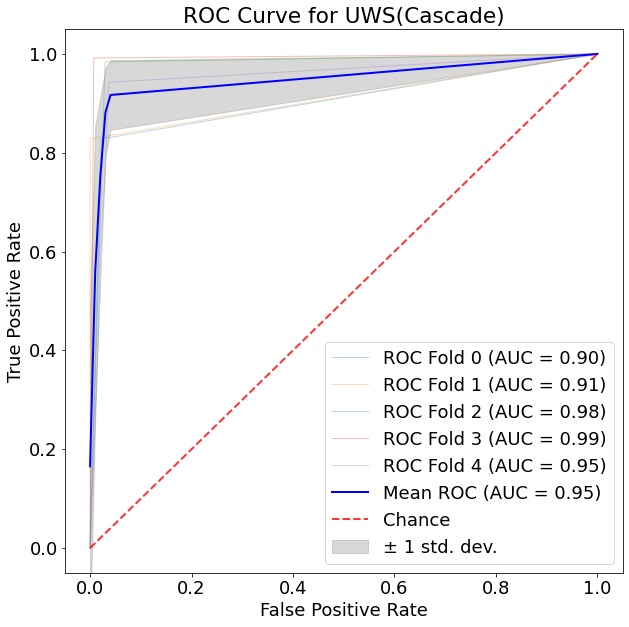

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 设置全局字体大小
plt.rcParams.update({'font.size': 18})  # 设置字体大小为 14
# 假设有五个模型的预测概率和真实标签
predict_labels_list = [predict_labels0, predict_labels1, predict_labels2, predict_labels3, predict_labels4]
true_labels_list = [true_labels0, true_labels1, true_labels2, true_labels3, true_labels4]
for pred in range(len(predict_labels_list)):
    predict_labels_list[pred] = predict_labels_list[pred].cpu().numpy()
for true_label in range(len(true_labels_list)):
     true_labels_list[true_label]= true_labels_list[true_label].cpu().numpy()
# 初始化绘图
plt.figure(figsize=(10, 10))

# 存储每个fold的假正率（fpr）和真正率（tpr）
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# 遍历每个fold的预测结果和真实标签
for i, (predict_labels, true_labels) in enumerate(zip(predict_labels_list, true_labels_list)):
    # 计算 ROC 曲线
    fpr, tpr, _ = roc_curve(true_labels, predict_labels)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)

    # 绘制当前fold的ROC曲线
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Fold {i} (AUC = {roc_auc:.2f})')

# 计算所有fold的均值和标准差
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)

# 绘制所有fold的平均ROC曲线
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# 绘制ROC曲线的标准差区域
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.3, label='± 1 std. dev.')

# 绘制对角线
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

# 设置图形属性
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for UWS(Cascade)')
plt.legend(loc='lower right')

plt.show()


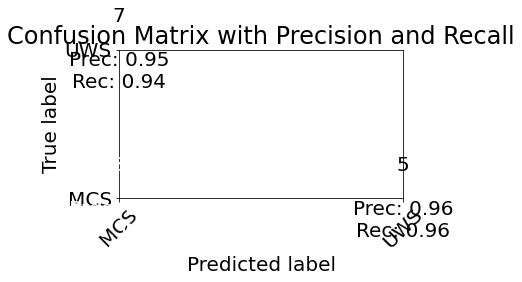

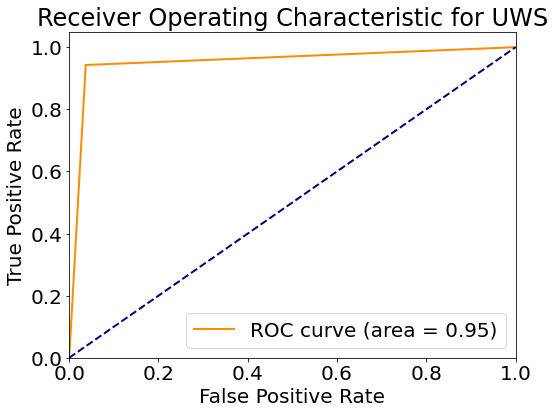

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
# 定义LSTM超参数
input_size = 64  # 输入特征维度
hidden_size = 64  # 隐藏单元数量
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数量
# fold0-4
exper_dir = "hc_doc"
# exper_dir = "mcs_uws"
model_name = "_CNN"
# model_name = "_CNN"
# model_name = "_CNN_spa"
# model_name = "_CNN_spa_lstm"
# model0 = MyNetwork(input_size, hidden_size, num_layers, output_size)
# model0.load_state_dict(torch.load(f"../model/mcs_uws/{exper_dir}{model_name}/Fold0_Epoch15.pt"))
# model1 = MyNetwork(input_size, hidden_size, num_layers, output_size)
# model1.load_state_dict(torch.load(f"../model/mcs_uws/{exper_dir}{model_name}/Fold1_Epoch15.pt"))
# model2 = MyNetwork(input_size, hidden_size, num_layers, output_size)
# model2.load_state_dict(torch.load(f"../model/mcs_uws/{exper_dir}{model_name}/Fold2_Epoch15.pt"))
# model3 = MyNetwork(input_size, hidden_size, num_layers, output_size)
# model3.load_state_dict(torch.load(f"../model/mcs_uws/{exper_dir}{model_name}/Fold3_Epoch15.pt"))
# model4 = MyNetwork(input_size, hidden_size, num_layers, output_size)
# model4.load_state_dict(torch.load(f"../model/mcs_uws/{exper_dir}{model_name}/Fold4_Epoch15.pt"))
# 设置全局字体大小
plt.rcParams.update({'font.size': 20})  # 设置字体大小为 14
# 假设有模型的预测结果和真实标签
# 例如，假设模型预测的结果存储在名为 predicted_labels 的数组中，
# 真实标签存储在名为 true_labels 的数组中
# 将张量转换为 NumPy 数组
# predict_labels = predict_labels.cpu().numpy()
# predict_labels = predict_labels.numpy()
# true_labels = true_labels.cpu().numpy()

# # 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predict_labels)

# 计算精确率和召回率
# 注意：在这里，MCS 是标签 0，UWS 是标签 1
precision = precision_score(true_labels, predict_labels, labels=[0, 1], average=None)
recall = recall_score(true_labels, predict_labels, labels=[0, 1], average=None)

# # 绘制混淆矩阵
# plt.figure(figsize=(10, 8))  # 设置图形大小
# plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.colorbar()

# 标记轴和标签
classes = ['MCS', 'UWS']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 添加数值标签和精确率/召回率信息（保持字体大小一致）
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]}\n\nPrec: {precision[j]:.2f}\nRec: {recall[i]:.2f}',
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Precision and Recall')
plt.show()

# 计算病例级别的分类概率
# 假设 p_i 是每个病例被分类为 MCS 的概率
# true_labels 中包含每个样本的真实标签，predicted_labels 中包含每个样本的预测标签
p_mcs = np.sum(predict_labels == 0) / len(true_labels)
p_uws = 1 - p_mcs

# 绘制 ROC 曲线
# 注意：这里计算 ROC 曲线的输入应该是真实标签和预测概率，而不是单个概率值 p_mcs
fpr, tpr, _ = roc_curve(true_labels, predict_labels)  # 根据预测概率计算 ROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))  # 设置 ROC 曲线图形大小
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for UWS')
plt.legend(loc='lower right')
plt.show()

# Draw Confusion Matrix

In [12]:
# ConditionB
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch19.pt")) # !!!!!!!!!!!!!!!!!!!!!
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold4_Epoch11.pt"))

# ConditionC
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold0_Epoch19.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold1_Epoch28.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold2_Epoch27.pt"))
# model.load_state_dict(torch.load(f"../model/{exper_dir}/Fold3_Epoch50.pt"))
# 假设有模型的预测结果和真实标签
#例如，假设模型预测的结果存储在名为 predicted_labels 的张量中，
# 真实标签存储在名为 true_labels 的张量中
# predicted_labels = torch.tensor([0, 1, 2, 1, 0, 2])
# true_labels = torch.tensor([0, 1, 2, 1, 0, 1])

# 将张量转换为 NumPy 数组
predict_labels = predict_labels.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predict_labels)

# 绘制混淆矩阵
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

# 标记轴和标签
classes = ['MCS', 'UWS']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 添加数值标签
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [10]:
del predict_labels
del true_labels
gc.collect()
torch.cuda.empty_cache()

In [34]:
import random
hc = torch.zeros([1231,1])
mcs = torch.zeros([1353,1])
uws = torch.zeros([1220,1])
# test dataset
# 生成随机种子
torch.manual_seed(32)
# 生成随机索引
hc_indices = torch.randperm(len(hc))
mcs_indices = torch.randperm(len(mcs))
uws_indices = torch.randperm(len(uws))
test_percentage = 0.1
test_end = int(test_percentage * len(hc))
test_hc_indices = hc_indices[:test_end]
test_end = int(test_percentage * len(mcs))
test_mcs_indices = mcs_indices[:test_end]
test_end = int(test_percentage * len(uws))
test_uws_indices = uws_indices[:test_end]
print(test_hc_indices)
print(test_mcs_indices)
print(test_uws_indices)

tensor([ 565,  234, 1112,  173,  194,  389,  455,  114, 1133,  160,  380,  452,
         774,   86,  473,    2, 1191, 1152,   62,  354,  313,  619,  793,  487,
         936,  217,  226,  271,  443,   55, 1159,  408,  753,  350,  284,  680,
         535, 1045, 1172,  439,  874,  734,  168,  768,  661,  386,  777,  858,
        1043,  857,  645,   29, 1033,  610,  190,  495,  986,  841,  449,   32,
        1218,  362, 1103,  108,  738,   38,  567,  534, 1020,  884,  180, 1186,
          48,  721,  907,  254,  464,  555,  531, 1151,  704,  425,  163,  918,
         556,  537, 1091,  961,  929, 1134,  878,  581,  909,  149,  317,  905,
         352,  188,  401,  323, 1138,  393, 1058,  356,  112,  144,  300,  891,
         722,  990, 1014,  795,  447, 1198, 1062,  337, 1197,  673,  546,   14,
         959,   44,  713])
tensor([1230,  753, 1259,  797,  294,  721,  651, 1088,  883,  503, 1143,  220,
        1191,  129,  572, 1180,  619, 1215,  233,  210,  639,  575,  385,  499,
        1321,